# Dereverb - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: , MATR: 953546 )

Import libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

### Part 1: RIR and reverberation
From the image we can see that values of beta should be chosen between 0.2 for small rooms (4 m per side) and 1.8 for very big rooms (30 m per side);

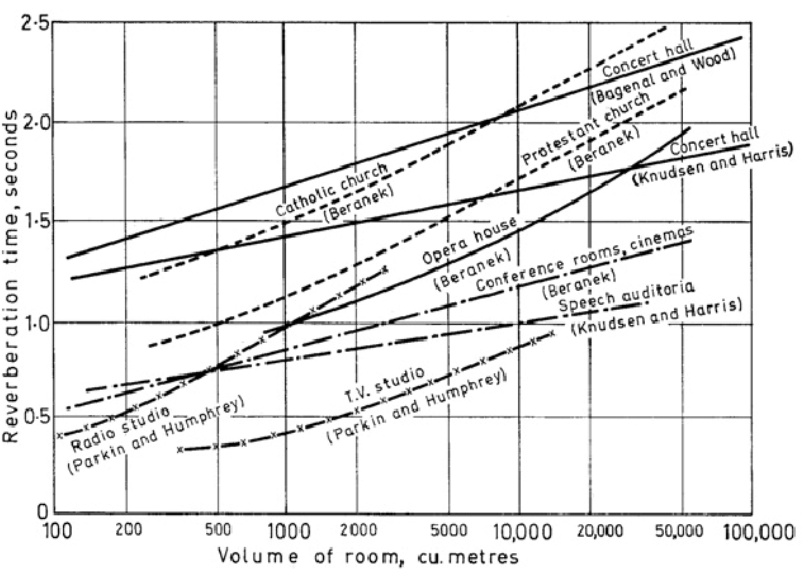

In [3]:
ipd.Image(filename = "images/RevTime1.png", width = 600, height = 300)

Let's define some parameters:

In [21]:
fs = 16000 # sampling rate (Hz)

rt60_tgt = 1.2  # reverberation time (s)
room_dim = [10, 7.5, 3.5]  # room dimensions (m)

source_pos = [5, 1, 1] # x, y, z position of the source (m)
mic_locs = np.c_[ [4.7, 6, 1.2], [5.3, 6, 1.2]] # location of the microphone / microphone array (m)

Visualization of the room with source and mics:

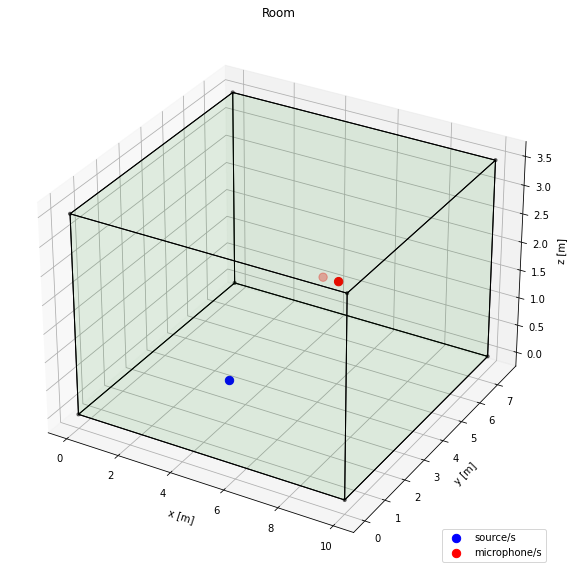

In [5]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

Now generate the RIR and apply it to the audio files

In [6]:
# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
audio, fs = librosa.load('audio/voiced_a.wav', sr=fs)

In [7]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 262.5 m³


In [8]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [9]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[1, 0]))

The desired RT60 was 1.2 s
The measured RT60 is 2.0469375000000003 s


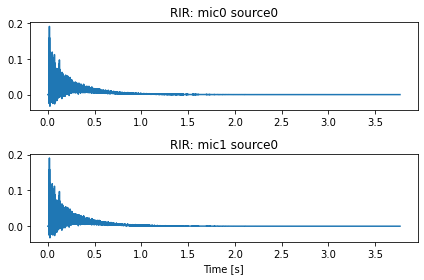

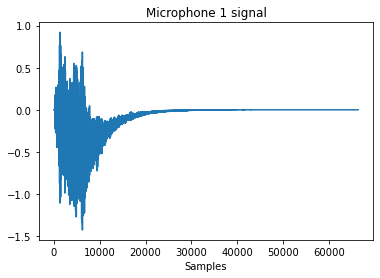

In [10]:
# Plot the RIRs
room.plot_rir()

plt.figure()
# plot signal at microphone 1
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Samples");

#### Audio files
Dry signal:

In [11]:
ipd.display(ipd.Audio(audio, rate=fs)) 

Reverberated signal:

In [12]:
ipd.display(ipd.Audio(room.mic_array.signals[0, :], rate=fs))

In [13]:
h=np.squeeze(np.asarray(room.rir))
H_f=np.fft.fft(h)
print(h.shape)
freqaxis=np.fft.fftfreq(len(h[0,:]))


(2, 60271)


In [14]:
print(np.squeeze(H_f).shape)
mag=np.abs(np.squeeze(H_f))**2
print(mag.shape)
phase=np.angle(np.squeeze(H_f))
print(mag.shape)
print(freqaxis.shape)

(2, 60271)
(2, 60271)
(2, 60271)
(60271,)


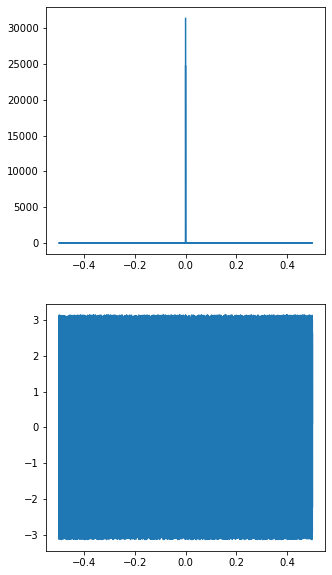

In [15]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.plot(freqaxis,mag[0,:])
plt.subplot(2,1,2)
plt.plot(freqaxis,phase[0,:])

/home/filippo/anaconda3/envs/SASP-Dereverb-Project/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/filippo/anaconda3/envs/SASP-Dereverb-Project/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


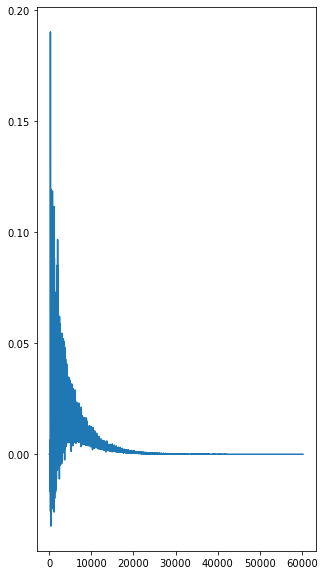

In [24]:
inversecheck=np.fft.ifft(H_f[0,:])
plt.figure(figsize=(5,10))
plt.plot(inversecheck)

In [ ]:
ipd.display(ipd.Audio(inversecheck, rate=fs))

In [25]:
ipd.display(ipd.Audio(room.rir[1][0], rate=fs))